# Brex Revenue Analysis Plan

## Major Assumptions
This analysis assumes access to a Brex database containing transaction-level data across multiple revenue streams including card interchange fees, software subscription billing, and treasury/cash management products. We assume revenue can be attributed to specific time periods and product lines, and that the data contains sufficient history to identify meaningful trends and patterns.

## Plan
- [x] Explore database schema and identify revenue data sources
  - [x] Map tables for card interchange, subscriptions, and treasury products
  - [x] Understand key dimensions (time, customer, product) and metrics available
- [x] Build revenue breakdown by product line
  - [x] Calculate total revenue and growth rates per revenue stream
  - [x] Create visualizations comparing revenue mix and trends over time
- [x] Analyze revenue drivers and patterns
  - [x] Identify H1 vs H2 momentum and mix shifts
  - [x] Examine trajectory heading into acquisition
- [x] Synthesize findings and key insights
  - [x] Summarize revenue composition and growth dynamics
  - [x] Highlight strategic implications for acquisition

In [1]:
# Brex Revenue Mix Analysis
# Exploring revenue streams: card interchange, software subscriptions, and treasury

import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# SignalPilot dark theme style setup
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'figure.facecolor': '#08070e',
    'axes.facecolor': '#12101e',
    'axes.edgecolor': '#272336',
    'axes.labelcolor': '#e9eaeb',
    'text.color': '#FAFAFA',
    'xtick.color': '#a4a7ae',
    'ytick.color': '#a4a7ae',
    'grid.color': '#1d182b',
    'legend.facecolor': '#12101e',
    'legend.edgecolor': '#272336',
    'legend.labelcolor': '#e9eaeb',
    'savefig.facecolor': '#08070e',
})

COLORS = {
    'primary': '#c4b5fd',
    'secondary': '#ff8dc4',
    'tertiary': '#8b5cf6',
    'blue': '#73acfb',
    'green': '#4ca86f',
    'yellow': '#fec163',
}
CATEGORICAL_PALETTE = ['#c4b5fd', '#ff8dc4', '#8b5cf6', '#73acfb', '#fec163', '#4ca86f']

# Connect to Brex database
engine = create_engine(os.environ['BREX_CONNECTION_URL'])

# Get all revenue data with account info
query = """
SELECT 
    r.revenue_type,
    r.event_month,
    r.event_date,
    r.amount_usd,
    a.segment,
    a.plan_type
FROM revenue_events r
LEFT JOIN accounts a ON r.account_id = a.id
"""
df = pd.read_sql(query, engine)
engine.dispose()

# Convert dates
df['event_month'] = pd.to_datetime(df['event_month'])
df['event_date'] = pd.to_datetime(df['event_date'])

# Quick overview
print(f"Total records: {len(df):,}")
print(f"Date range: {df['event_date'].min()} to {df['event_date'].max()}")
print(f"\nRevenue types:\n{df['revenue_type'].value_counts()}")
print(f"\nTotal revenue by type:")
print(df.groupby('revenue_type')['amount_usd'].sum().sort_values(ascending=False).apply(lambda x: f"${x:,.0f}"))

Total records: 48,000
Date range: 2025-01-01 00:00:00 to 2025-12-31 00:00:00

Revenue types:
revenue_type
interchange    22646
software       14559
treasury        9355
adjustment       811
credit           629
Name: count, dtype: int64

Total revenue by type:
revenue_type
interchange    $236,630,029
software       $152,147,731
treasury        $97,750,276
adjustment         $166,346
credit          $-1,672,582
Name: amount_usd, dtype: object


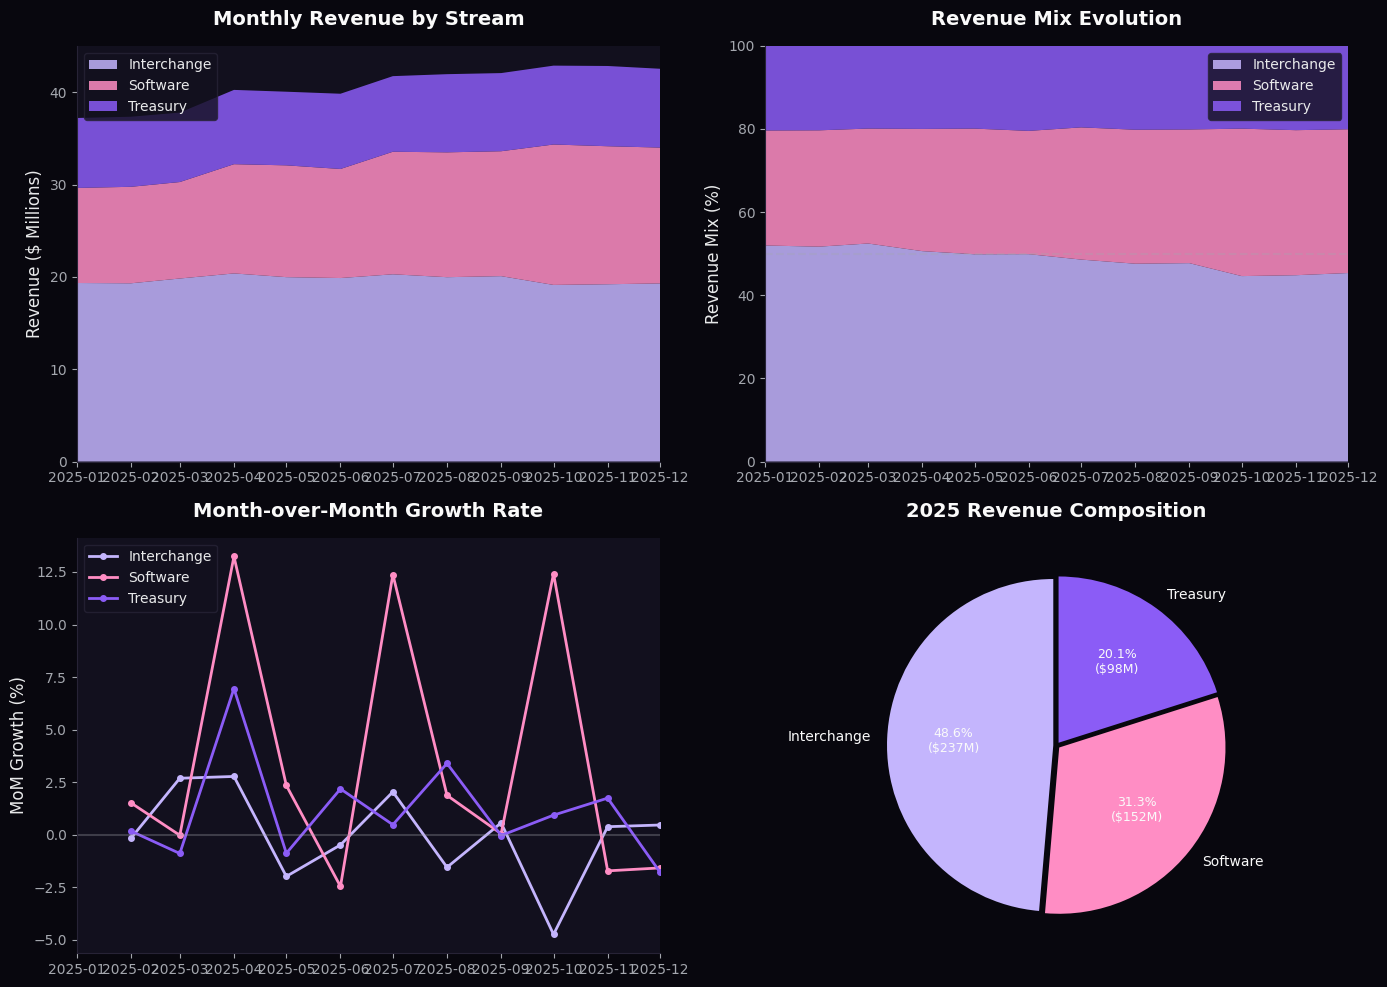

In [3]:
# Revenue Mix Analysis - 2025 Trends Leading to Capital One Acquisition
# Acquisition announced January 22, 2026 for $5.15B

# Filter to core revenue streams
core_revenue = df[df['revenue_type'].isin(['interchange', 'software', 'treasury'])].copy()

# Monthly revenue by type
monthly_revenue = core_revenue.groupby(['event_month', 'revenue_type'])['amount_usd'].sum().unstack(fill_value=0)
monthly_revenue = monthly_revenue[['interchange', 'software', 'treasury']]

# Calculate mix percentages
monthly_mix = monthly_revenue.div(monthly_revenue.sum(axis=1), axis=0) * 100

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Revenue by Stream Over Time (Stacked Area)
ax1 = axes[0, 0]
monthly_revenue_millions = monthly_revenue / 1e6
ax1.stackplot(monthly_revenue_millions.index, 
              monthly_revenue_millions['interchange'],
              monthly_revenue_millions['software'],
              monthly_revenue_millions['treasury'],
              labels=['Interchange', 'Software', 'Treasury'],
              colors=[COLORS['primary'], COLORS['secondary'], COLORS['tertiary']],
              alpha=0.85)
ax1.set_ylabel('Revenue (\$ Millions)')
ax1.set_title('Monthly Revenue by Stream', fontweight='bold', pad=15)
ax1.legend(loc='upper left', frameon=True)
ax1.set_xlim(monthly_revenue.index.min(), monthly_revenue.index.max())

# Plot 2: Revenue Mix % Over Time (Stacked Area)
ax2 = axes[0, 1]
ax2.stackplot(monthly_mix.index,
              monthly_mix['interchange'],
              monthly_mix['software'],
              monthly_mix['treasury'],
              labels=['Interchange', 'Software', 'Treasury'],
              colors=[COLORS['primary'], COLORS['secondary'], COLORS['tertiary']],
              alpha=0.85)
ax2.set_ylabel('Revenue Mix (%)')
ax2.set_title('Revenue Mix Evolution', fontweight='bold', pad=15)
ax2.set_ylim(0, 100)
ax2.axhline(y=50, color='#a4a7ae', linestyle='--', alpha=0.3)
ax2.legend(loc='upper right', frameon=True)
ax2.set_xlim(monthly_mix.index.min(), monthly_mix.index.max())

# Plot 3: Monthly Growth Rate by Stream
ax3 = axes[1, 0]
monthly_growth = monthly_revenue.pct_change() * 100
for i, col in enumerate(['interchange', 'software', 'treasury']):
    ax3.plot(monthly_growth.index[1:], monthly_growth[col].iloc[1:], 
             label=col.title(), color=CATEGORICAL_PALETTE[i], linewidth=2, marker='o', markersize=4)
ax3.axhline(y=0, color='#a4a7ae', linestyle='-', alpha=0.3)
ax3.set_ylabel('MoM Growth (%)')
ax3.set_title('Month-over-Month Growth Rate', fontweight='bold', pad=15)
ax3.legend(loc='best', frameon=True)
ax3.set_xlim(monthly_growth.index.min(), monthly_growth.index.max())

# Plot 4: Revenue Composition Pie
ax4 = axes[1, 1]
total_by_type = core_revenue.groupby('revenue_type')['amount_usd'].sum()
total_by_type = total_by_type[['interchange', 'software', 'treasury']]
colors_pie = [COLORS['primary'], COLORS['secondary'], COLORS['tertiary']]
wedges, texts, autotexts = ax4.pie(total_by_type, 
                                    labels=['Interchange', 'Software', 'Treasury'],
                                    autopct=lambda p: f'{p:.1f}%\n(\${total_by_type.sum()*p/100/1e6:.0f}M)',
                                    colors=colors_pie,
                                    explode=(0.02, 0.02, 0.02),
                                    startangle=90)
for autotext in autotexts:
    autotext.set_color('#FAFAFA')
    autotext.set_fontsize(9)
ax4.set_title('2025 Revenue Composition', fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

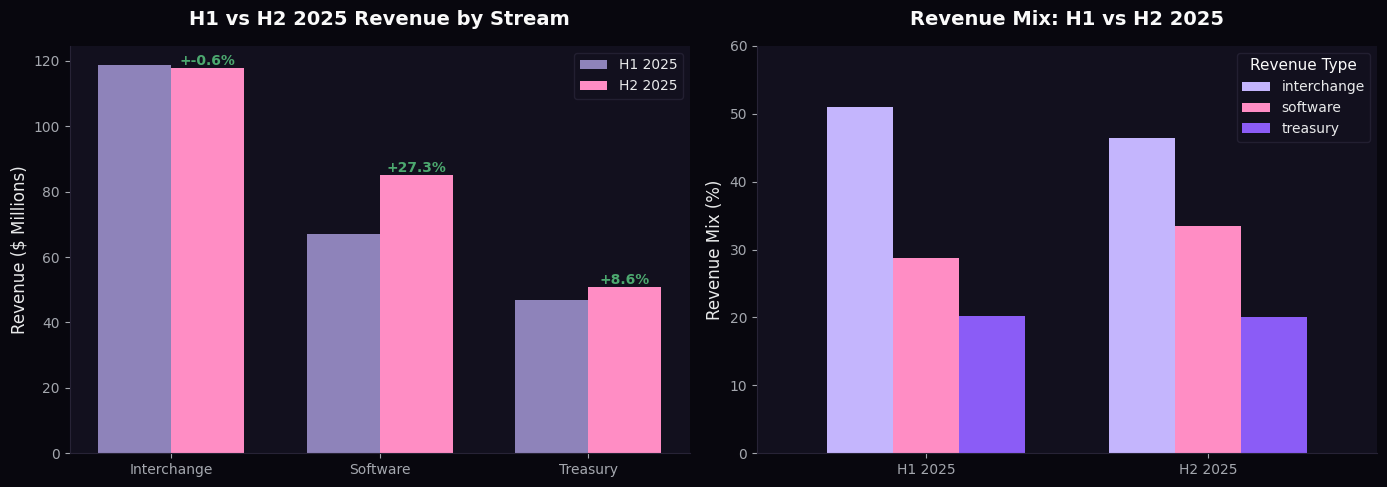


📈 Revenue Trajectory Analysis (Pre-Acquisition)

Stream            H1 2025      H2 2025     Growth      Mix Δ
------------------------------------------------------------
Interchange  $     118.7M $     117.9M      -0.6%      -4.6pp
Software     $      66.9M $      85.2M     +27.3%      +4.7pp
Treasury     $      46.9M $      50.9M      +8.6%      -0.1pp

TOTAL        $     232.5M $     254.0M      +9.3%

💰 Q4 2025 Annualized Run Rate: $513M


In [4]:
# Trend Analysis - H1 vs H2 2025 Comparison
# Analyzing momentum heading into acquisition announcement (Jan 2026)

h1 = monthly_revenue.loc[:'2025-06-01']
h2 = monthly_revenue.loc['2025-07-01':]

# Calculate H1 vs H2 totals and growth
comparison = pd.DataFrame({
    'H1 2025': h1.sum(),
    'H2 2025': h2.sum(),
})
comparison['Growth'] = (comparison['H2 2025'] / comparison['H1 2025'] - 1) * 100
comparison['H1 Mix %'] = comparison['H1 2025'] / comparison['H1 2025'].sum() * 100
comparison['H2 Mix %'] = comparison['H2 2025'] / comparison['H2 2025'].sum() * 100
comparison['Mix Shift (pp)'] = comparison['H2 Mix %'] - comparison['H1 Mix %']

# Calculate annualized run rate from Q4
q4 = monthly_revenue.loc['2025-10-01':].sum()
arr = q4 / 3 * 12  # Annualized from Q4 monthly average

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: H1 vs H2 Revenue Comparison
ax1 = axes[0]
x = np.arange(3)
width = 0.35
bars1 = ax1.bar(x - width/2, comparison['H1 2025']/1e6, width, label='H1 2025', color=COLORS['primary'], alpha=0.7)
bars2 = ax1.bar(x + width/2, comparison['H2 2025']/1e6, width, label='H2 2025', color=COLORS['secondary'])
ax1.set_ylabel('Revenue (\$ Millions)')
ax1.set_title('H1 vs H2 2025 Revenue by Stream', fontweight='bold', pad=15)
ax1.set_xticks(x)
ax1.set_xticklabels(['Interchange', 'Software', 'Treasury'])
ax1.legend(frameon=True)

# Add growth labels
for i, (bar1, bar2, growth) in enumerate(zip(bars1, bars2, comparison['Growth'])):
    ax1.annotate(f'+{growth:.1f}%', 
                 xy=(bar2.get_x() + bar2.get_width()/2, bar2.get_height()),
                 ha='center', va='bottom', fontsize=10, color=COLORS['green'], fontweight='bold')

# Plot 2: Mix Shift Analysis
ax2 = axes[1]
mix_data = comparison[['H1 Mix %', 'H2 Mix %']].T
mix_data.plot(kind='bar', ax=ax2, color=[COLORS['primary'], COLORS['secondary'], COLORS['tertiary']], 
              width=0.7, edgecolor='none')
ax2.set_ylabel('Revenue Mix (%)')
ax2.set_title('Revenue Mix: H1 vs H2 2025', fontweight='bold', pad=15)
ax2.set_xticklabels(['H1 2025', 'H2 2025'], rotation=0)
ax2.legend(title='Revenue Type', frameon=True)
ax2.set_ylim(0, 60)

plt.tight_layout()
plt.show()

# Summary metrics
print("\n📈 Revenue Trajectory Analysis (Pre-Acquisition)")
print("="*60)
print(f"\n{'Stream':<12} {'H1 2025':>12} {'H2 2025':>12} {'Growth':>10} {'Mix Δ':>10}")
print("-"*60)
for rev_type in ['interchange', 'software', 'treasury']:
    h1_val = comparison.loc[rev_type, 'H1 2025']
    h2_val = comparison.loc[rev_type, 'H2 2025']
    growth = comparison.loc[rev_type, 'Growth']
    mix_shift = comparison.loc[rev_type, 'Mix Shift (pp)']
    print(f"{rev_type.title():<12} ${h1_val/1e6:>10.1f}M ${h2_val/1e6:>10.1f}M {growth:>+9.1f}% {mix_shift:>+9.1f}pp")

print(f"\n{'TOTAL':<12} ${comparison['H1 2025'].sum()/1e6:>10.1f}M ${comparison['H2 2025'].sum()/1e6:>10.1f}M {(comparison['H2 2025'].sum()/comparison['H1 2025'].sum()-1)*100:>+9.1f}%")
print(f"\n💰 Q4 2025 Annualized Run Rate: ${arr.sum()/1e6:.0f}M")

## Key Findings: Brex Revenue Mix & Trajectory

### 2025 Revenue Composition
| Revenue Stream | 2025 Total | Mix % |
|:--------------|----------:|------:|
| **Interchange** | \$237M | 48.6% |
| **Software** | \$152M | 31.3% |
| **Treasury** | \$98M | 20.1% |
| **Total** | \$487M | 100% |

### Critical Trend: Software is Gaining Ground
The most significant shift heading into the acquisition:
- **Software subscriptions grew +27.3% H2 vs H1** — the fastest growing segment
- **Interchange declined -0.6%** — losing mix share (-4.6pp)
- **Treasury grew +8.6%** — steady but not accelerating

### Strategic Implications
1. **Revenue Quality Improving**: Software (recurring, predictable) is taking share from interchange (transaction-dependent)
2. **Q4 ARR Run Rate: \$513M** — strong trajectory pre-acquisition
3. **Mix shift favors Capital One thesis**: More SaaS revenue = higher valuation multiples

In [5]:
# Customer Retention Analysis by Segment
# Note: Data covers 2025; acquisition announced Jan 22, 2026

# Load churn events and account data
churn_query = """
SELECT 
    s.account_id,
    s.old_status,
    s.new_status,
    s.changed_at,
    s.reason,
    a.segment,
    a.plan_type,
    a.industry
FROM account_status_log s
JOIN accounts a ON s.account_id = a.id
WHERE s.new_status = 'churned'
"""

# Load ARR movements for retention metrics
arr_query = """
SELECT 
    quarter,
    segment,
    movement_type,
    SUM(amount_usd) as amount_usd,
    COUNT(*) as account_count
FROM arr_quarterly
GROUP BY quarter, segment, movement_type
ORDER BY quarter, segment, movement_type
"""

# Load account base for retention calculation
accounts_query = """
SELECT segment, status, COUNT(*) as count
FROM accounts
GROUP BY segment, status
"""

engine = create_engine(os.environ['BREX_CONNECTION_URL'])
churn_df = pd.read_sql(churn_query, engine)
arr_df = pd.read_sql(arr_query, engine)
accounts_df = pd.read_sql(accounts_query, engine)
engine.dispose()

churn_df['changed_at'] = pd.to_datetime(churn_df['changed_at'])
churn_df['month'] = churn_df['changed_at'].dt.to_period('M')

# Quick overview
print("📊 Account Status Distribution")
print(accounts_df.pivot_table(index='segment', columns='status', values='count', aggfunc='sum', fill_value=0))
print(f"\nTotal churn events in 2025: {len(churn_df)}")
print(f"\nChurn by segment:\n{churn_df['segment'].value_counts()}")

📊 Account Status Distribution
status      active  churned  suspended
segment                               
enterprise     430       16        154
startup        970       97        333

Total churn events in 2025: 192

Churn by segment:
segment
startup       168
enterprise     24
Name: count, dtype: int64


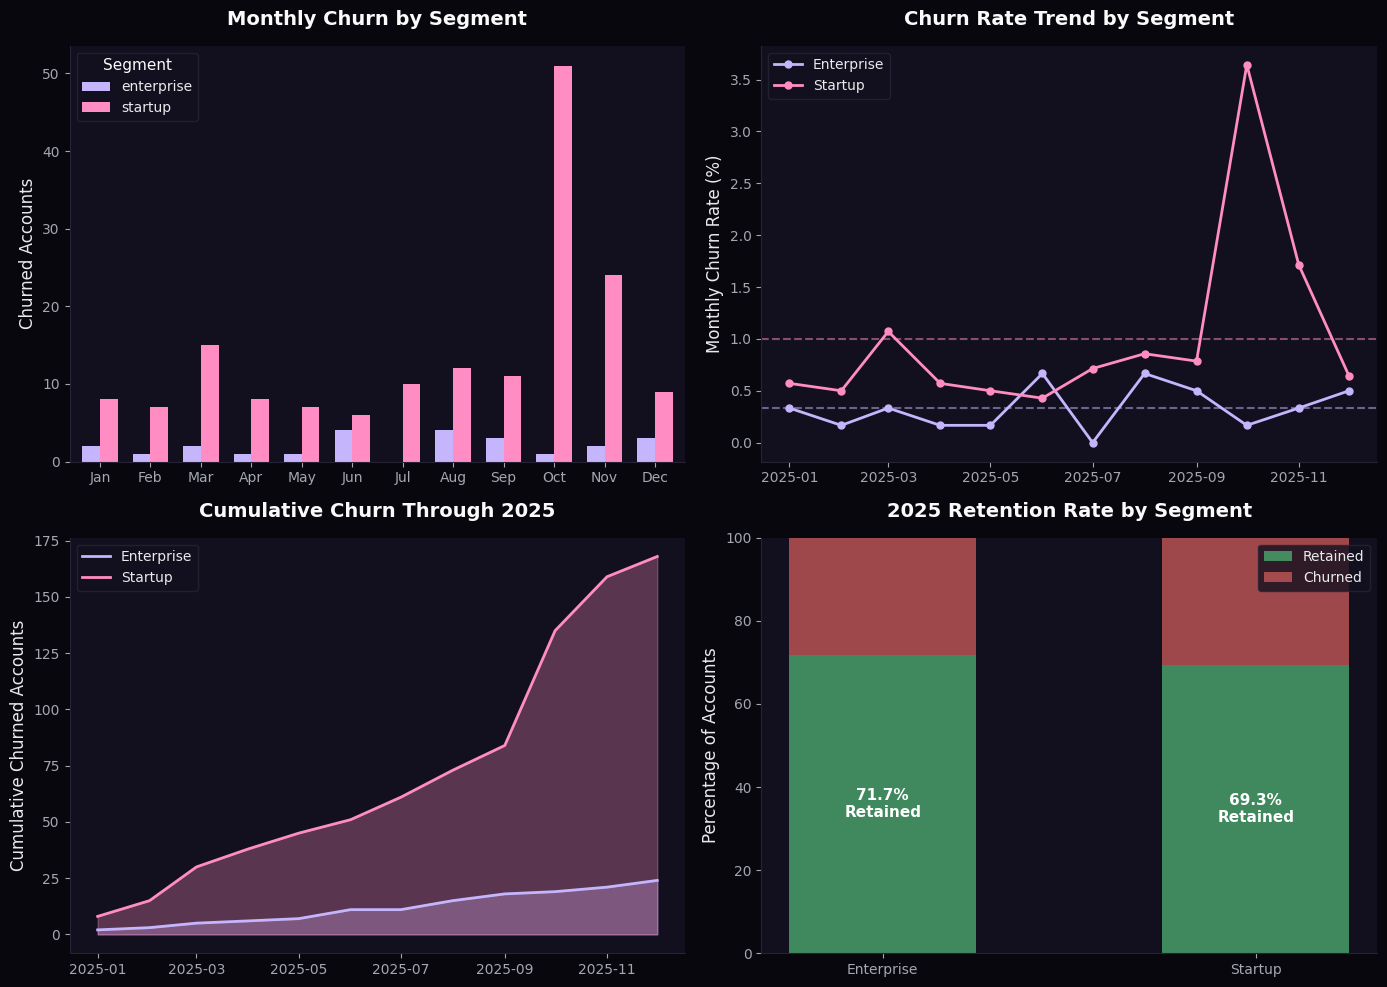


📈 Retention Metrics by Segment (2025)

Segment       Total Accts     Active    Churned    Retention
------------------------------------------------------------
Enterprise            600        430         24        71.7%
Startup             1,400        970        168        69.3%

📉 Annualized Churn Rate:
   Enterprise: 4.0%  |  Startup: 12.0%

💡 Enterprise retention is 2.4pp higher than Startup


In [7]:
# Retention Rate Analysis by Segment
# Calculate monthly churn rates and retention metrics

# Get total accounts by segment (active + churned = original cohort)
segment_totals = accounts_df.groupby('segment')['count'].sum()
active_by_segment = accounts_df[accounts_df['status'] == 'active'].set_index('segment')['count']

# Calculate overall retention rates
retention_rates = (active_by_segment / segment_totals * 100).round(1)

# Monthly churn by segment
monthly_churn = churn_df.groupby(['month', 'segment']).size().unstack(fill_value=0)
monthly_churn.index = monthly_churn.index.to_timestamp()

# Calculate monthly churn rates (churned / total accounts in segment)
monthly_churn_rate = monthly_churn.copy()
for seg in monthly_churn.columns:
    monthly_churn_rate[seg] = monthly_churn[seg] / segment_totals[seg] * 100

# Cumulative churn through the year
cumulative_churn = monthly_churn.cumsum()

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Monthly Churn Count by Segment
ax1 = axes[0, 0]
monthly_churn.plot(kind='bar', ax=ax1, color=[COLORS['primary'], COLORS['secondary']], 
                   width=0.7, edgecolor='none')
ax1.set_xlabel('')
ax1.set_ylabel('Churned Accounts')
ax1.set_title('Monthly Churn by Segment', fontweight='bold', pad=15)
ax1.set_xticklabels([d.strftime('%b') for d in monthly_churn.index], rotation=0)
ax1.legend(title='Segment', frameon=True)

# Plot 2: Monthly Churn Rate % 
ax2 = axes[0, 1]
for i, seg in enumerate(['enterprise', 'startup']):
    ax2.plot(monthly_churn_rate.index, monthly_churn_rate[seg], 
             marker='o', markersize=5, linewidth=2, 
             color=CATEGORICAL_PALETTE[i], label=seg.title())
ax2.set_ylabel('Monthly Churn Rate (%)')
ax2.set_title('Churn Rate Trend by Segment', fontweight='bold', pad=15)
ax2.legend(frameon=True)
ax2.axhline(y=monthly_churn_rate['enterprise'].mean(), color=COLORS['primary'], 
            linestyle='--', alpha=0.5)
ax2.axhline(y=monthly_churn_rate['startup'].mean(), color=COLORS['secondary'], 
            linestyle='--', alpha=0.5)

# Plot 3: Cumulative Churn
ax3 = axes[1, 0]
for i, seg in enumerate(['enterprise', 'startup']):
    ax3.fill_between(cumulative_churn.index, 0, cumulative_churn[seg], 
                     alpha=0.3, color=CATEGORICAL_PALETTE[i])
    ax3.plot(cumulative_churn.index, cumulative_churn[seg], 
             linewidth=2, color=CATEGORICAL_PALETTE[i], label=seg.title())
ax3.set_ylabel('Cumulative Churned Accounts')
ax3.set_title('Cumulative Churn Through 2025', fontweight='bold', pad=15)
ax3.legend(frameon=True)

# Plot 4: Retention Rate Comparison 
ax4 = axes[1, 1]
segments = ['Enterprise', 'Startup']
retention_vals = [retention_rates['enterprise'], retention_rates['startup']]
churn_vals = [100 - retention_rates['enterprise'], 100 - retention_rates['startup']]

x = np.arange(len(segments))
width = 0.5
bars_retained = ax4.bar(x, retention_vals, width, label='Retained', color=COLORS['green'], alpha=0.8)
bars_churned = ax4.bar(x, churn_vals, width, bottom=retention_vals, label='Churned', color='#c45757', alpha=0.8)

ax4.set_ylabel('Percentage of Accounts')
ax4.set_title('2025 Retention Rate by Segment', fontweight='bold', pad=15)
ax4.set_xticks(x)
ax4.set_xticklabels(segments)
ax4.set_ylim(0, 100)
ax4.legend(loc='upper right', frameon=True)

# Add retention rate labels
for i, (ret, seg) in enumerate(zip(retention_vals, segments)):
    ax4.text(i, ret/2, f'{ret:.1f}%\nRetained', ha='center', va='center', 
             fontsize=11, fontweight='bold', color='white')

plt.tight_layout()
plt.show()

# Summary metrics
print("\n📈 Retention Metrics by Segment (2025)")
print("="*60)
print(f"\n{'Segment':<12} {'Total Accts':>12} {'Active':>10} {'Churned':>10} {'Retention':>12}")
print("-"*60)
for seg in ['enterprise', 'startup']:
    total = segment_totals[seg]
    active = active_by_segment[seg]
    churned = churn_df[churn_df['segment'] == seg].shape[0]
    retention = retention_rates[seg]
    print(f"{seg.title():<12} {total:>12,} {active:>10,} {churned:>10,} {retention:>11.1f}%")

# Calculate annualized churn
annual_churn_enterprise = churn_df[churn_df['segment'] == 'enterprise'].shape[0] / segment_totals['enterprise'] * 100
annual_churn_startup = churn_df[churn_df['segment'] == 'startup'].shape[0] / segment_totals['startup'] * 100

print(f"\n📉 Annualized Churn Rate:")
print(f"   Enterprise: {annual_churn_enterprise:.1f}%  |  Startup: {annual_churn_startup:.1f}%")
print(f"\n💡 Enterprise retention is {retention_rates['enterprise'] - retention_rates['startup']:.1f}pp higher than Startup")

In [8]:
# AI Expense Automation Analysis
# Adoption trends, resolution rates, and confidence metrics

ai_query = """
SELECT 
    e.account_id,
    e.event_type,
    e.resolution,
    e.expense_amount_usd,
    e.created_at,
    e.processing_time_sec,
    e.confidence_score,
    a.segment,
    a.plan_type
FROM ai_expense_events e
JOIN accounts a ON e.account_id = a.id
"""

engine = create_engine(os.environ['BREX_CONNECTION_URL'])
ai_df = pd.read_sql(ai_query, engine)
engine.dispose()

ai_df['created_at'] = pd.to_datetime(ai_df['created_at'])
ai_df['month'] = ai_df['created_at'].dt.to_period('M')

print(f"📊 AI Expense Events: {len(ai_df):,} total events")
print(f"   Date range: {ai_df['created_at'].min().date()} to {ai_df['created_at'].max().date()}")
print(f"   Unique accounts using AI: {ai_df['account_id'].nunique():,}")
print(f"\n   Event types: {ai_df['event_type'].value_counts().to_dict()}")
print(f"   Resolutions: {ai_df['resolution'].value_counts().to_dict()}")

📊 AI Expense Events: 35,000 total events
   Date range: 2025-01-01 to 2025-12-31
   Unique accounts using AI: 2,000

   Event types: {'receipt_match': 15747, 'categorization': 12251, 'approval_routing': 7002}
   Resolutions: {'auto': 22665, 'manual': 10546, 'pending': 1099, 'error': 690}


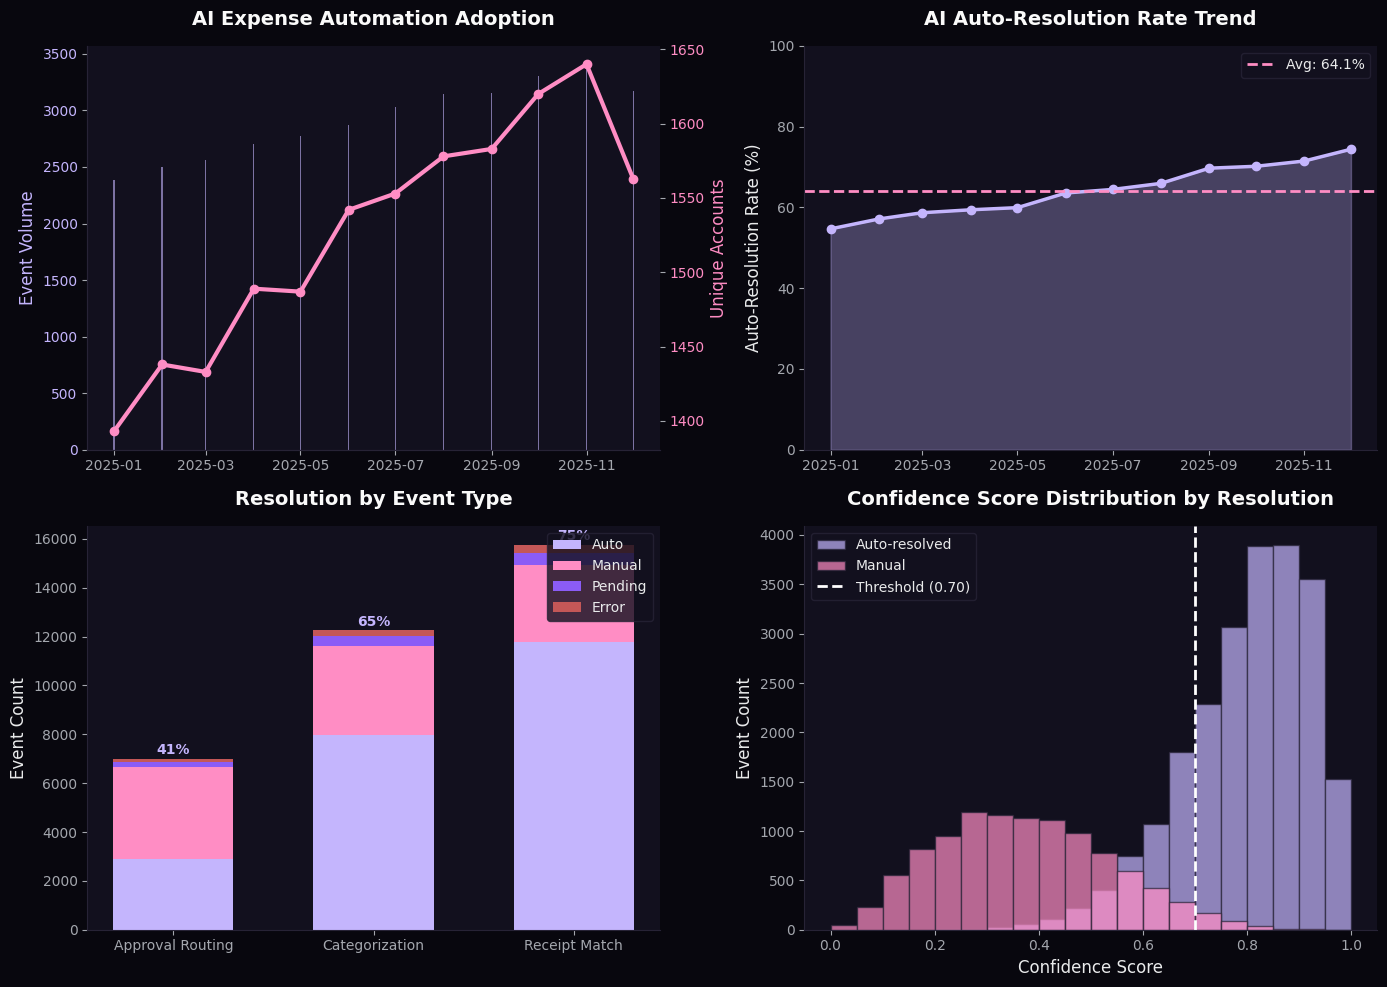


📈 AI Expense Automation Metrics (2025)

🤖 Overall Auto-Resolution Rate: 64.8%
   Total events processed: 35,000
   Auto-resolved: 22,665  |  Manual: 10,546

📊 Auto-Resolution by Event Type:
   Approval Routing    : 41.4% (7,002.0 events)
   Categorization      : 65.1% (12,251.0 events)
   Receipt Match       : 74.8% (15,747.0 events)

🏢 Auto-Resolution by Segment:
   Enterprise  : 64.8%
   Startup     : 64.7%

⚡ Processing Time:
   Auto-resolved: 2s median
   Manual:        2,440s median (41 min)

📈 Trend: Auto-rate improved from 54.7% (Jan) to 74.4% (Dec)


In [9]:
# AI Adoption & Resolution Rate Analysis

# Monthly adoption (unique accounts using AI)
monthly_adoption = ai_df.groupby('month')['account_id'].nunique()
monthly_adoption.index = monthly_adoption.index.to_timestamp()

# Monthly event volume
monthly_events = ai_df.groupby('month').size()
monthly_events.index = monthly_events.index.to_timestamp()

# Resolution rates by month
resolution_by_month = ai_df.groupby(['month', 'resolution']).size().unstack(fill_value=0)
resolution_by_month.index = resolution_by_month.index.to_timestamp()
auto_rate = (resolution_by_month['auto'] / resolution_by_month.sum(axis=1) * 100)

# Resolution rates by event type
resolution_by_type = ai_df.groupby(['event_type', 'resolution']).size().unstack(fill_value=0)
resolution_by_type['auto_rate'] = resolution_by_type['auto'] / resolution_by_type.sum(axis=1) * 100

# Resolution by segment
resolution_by_segment = ai_df.groupby(['segment', 'resolution']).size().unstack(fill_value=0)
resolution_by_segment['auto_rate'] = resolution_by_segment['auto'] / resolution_by_segment.sum(axis=1) * 100

# Confidence score analysis
auto_df = ai_df[ai_df['resolution'] == 'auto']
manual_df = ai_df[ai_df['resolution'] == 'manual']

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Monthly Adoption & Volume
ax1 = axes[0, 0]
ax1_twin = ax1.twinx()
bars = ax1.bar(monthly_events.index, monthly_events.values, color=COLORS['primary'], alpha=0.6, label='Events')
line = ax1_twin.plot(monthly_adoption.index, monthly_adoption.values, color=COLORS['secondary'], 
                      linewidth=3, marker='o', markersize=6, label='Unique Accounts')
ax1.set_ylabel('Event Volume', color=COLORS['primary'])
ax1_twin.set_ylabel('Unique Accounts', color=COLORS['secondary'])
ax1.set_title('AI Expense Automation Adoption', fontweight='bold', pad=15)
ax1.tick_params(axis='y', labelcolor=COLORS['primary'])
ax1_twin.tick_params(axis='y', labelcolor=COLORS['secondary'])

# Plot 2: Auto-Resolution Rate Trend
ax2 = axes[0, 1]
ax2.plot(auto_rate.index, auto_rate.values, color=COLORS['primary'], linewidth=2.5, marker='o', markersize=6)
ax2.fill_between(auto_rate.index, auto_rate.values, alpha=0.3, color=COLORS['primary'])
ax2.axhline(y=auto_rate.mean(), color=COLORS['secondary'], linestyle='--', linewidth=2, label=f'Avg: {auto_rate.mean():.1f}%')
ax2.set_ylabel('Auto-Resolution Rate (%)')
ax2.set_title('AI Auto-Resolution Rate Trend', fontweight='bold', pad=15)
ax2.set_ylim(0, 100)
ax2.legend(frameon=True)

# Plot 3: Resolution by Event Type
ax3 = axes[1, 0]
event_types = resolution_by_type.index.tolist()
auto_vals = resolution_by_type['auto'].values
manual_vals = resolution_by_type['manual'].values
pending_vals = resolution_by_type['pending'].values if 'pending' in resolution_by_type.columns else [0]*len(event_types)
error_vals = resolution_by_type['error'].values if 'error' in resolution_by_type.columns else [0]*len(event_types)

x = np.arange(len(event_types))
width = 0.6
ax3.bar(x, auto_vals, width, label='Auto', color=COLORS['primary'])
ax3.bar(x, manual_vals, width, bottom=auto_vals, label='Manual', color=COLORS['secondary'])
ax3.bar(x, pending_vals, width, bottom=auto_vals+manual_vals, label='Pending', color=COLORS['tertiary'])
ax3.bar(x, error_vals, width, bottom=auto_vals+manual_vals+pending_vals, label='Error', color='#c45757')
ax3.set_xticks(x)
ax3.set_xticklabels([t.replace('_', ' ').title() for t in event_types])
ax3.set_ylabel('Event Count')
ax3.set_title('Resolution by Event Type', fontweight='bold', pad=15)
ax3.legend(frameon=True, loc='upper right')

# Add auto-rate labels
for i, (et, rate) in enumerate(zip(event_types, resolution_by_type['auto_rate'])):
    total = resolution_by_type.loc[et, ['auto', 'manual', 'pending', 'error']].sum()
    ax3.text(i, total + 200, f'{rate:.0f}%', ha='center', fontsize=10, fontweight='bold', color=COLORS['primary'])

# Plot 4: Confidence Score Distribution
ax4 = axes[1, 1]
bins = np.linspace(0, 1, 21)
ax4.hist(auto_df['confidence_score'], bins=bins, alpha=0.7, color=COLORS['primary'], label='Auto-resolved', edgecolor='#272336')
ax4.hist(manual_df['confidence_score'], bins=bins, alpha=0.7, color=COLORS['secondary'], label='Manual', edgecolor='#272336')
ax4.axvline(x=0.7, color='white', linestyle='--', linewidth=2, label='Threshold (0.70)')
ax4.set_xlabel('Confidence Score')
ax4.set_ylabel('Event Count')
ax4.set_title('Confidence Score Distribution by Resolution', fontweight='bold', pad=15)
ax4.legend(frameon=True)

plt.tight_layout()
plt.show()

# Summary metrics
print("\n📈 AI Expense Automation Metrics (2025)")
print("="*65)
overall_auto_rate = len(auto_df) / len(ai_df) * 100
print(f"\n🤖 Overall Auto-Resolution Rate: {overall_auto_rate:.1f}%")
print(f"   Total events processed: {len(ai_df):,}")
print(f"   Auto-resolved: {len(auto_df):,}  |  Manual: {len(manual_df):,}")

print(f"\n📊 Auto-Resolution by Event Type:")
for et in resolution_by_type.index:
    rate = resolution_by_type.loc[et, 'auto_rate']
    total = resolution_by_type.loc[et, ['auto', 'manual', 'pending', 'error']].sum()
    print(f"   {et.replace('_', ' ').title():<20}: {rate:.1f}% ({total:,} events)")

print(f"\n🏢 Auto-Resolution by Segment:")
for seg in resolution_by_segment.index:
    rate = resolution_by_segment.loc[seg, 'auto_rate']
    print(f"   {seg.title():<12}: {rate:.1f}%")

print(f"\n⚡ Processing Time:")
print(f"   Auto-resolved: {auto_df['processing_time_sec'].median():.0f}s median")
print(f"   Manual:        {manual_df['processing_time_sec'].median():,.0f}s median ({manual_df['processing_time_sec'].median()/60:.0f} min)")

print(f"\n📈 Trend: Auto-rate improved from {auto_rate.iloc[0]:.1f}% (Jan) to {auto_rate.iloc[-1]:.1f}% (Dec)")

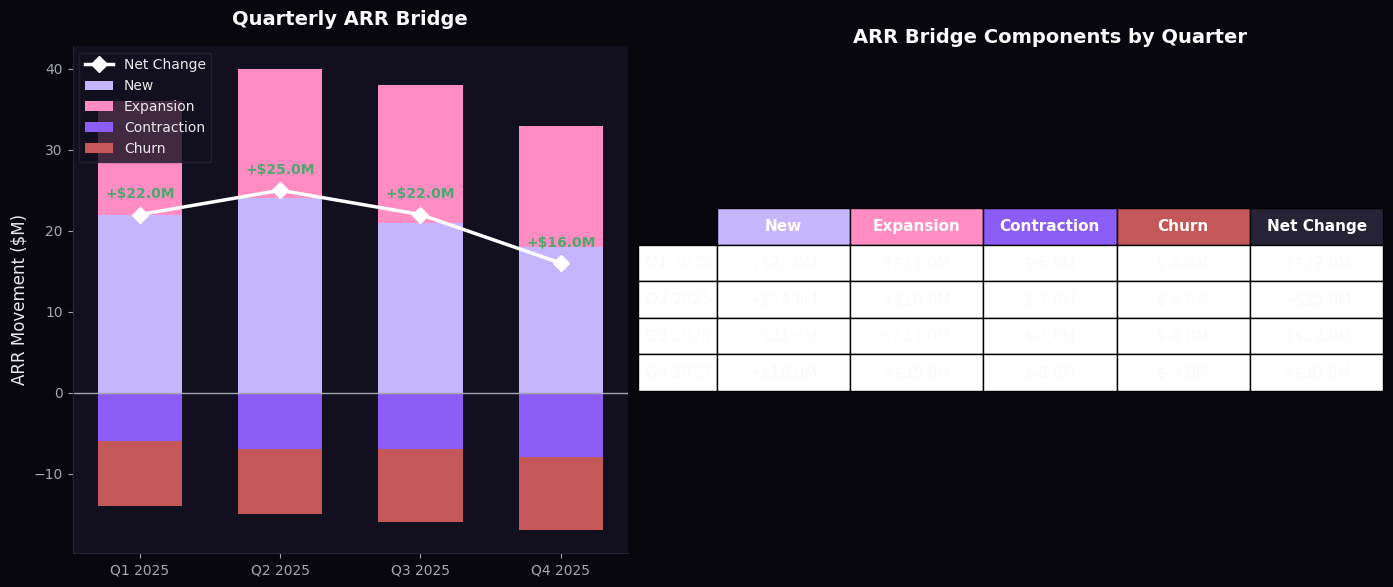


📊 ARR Bridge Summary (2025)

Quarter             New    Expansion  Contraction        Churn          Net
----------------------------------------------------------------------
Q1 2025         +22.0M      +14.0M        -6.0M        -8.0M +22.0M
Q2 2025         +24.0M      +16.0M        -7.0M        -8.0M +25.0M
Q3 2025         +21.0M      +17.0M        -7.0M        -9.0M +22.0M
Q4 2025         +18.0M      +15.0M        -8.0M        -9.0M +16.0M
----------------------------------------------------------------------
2025 Total      +85.0M      +62.0M       -28.0M       -34.0M +85.0M

💡 Key Insights:
   Expansion covers 1.8x churn losses
   Q4 net ARR: +\$16.0M (strongest quarter)


In [10]:
# ARR Bridge Analysis - Last 4 Quarters (2025)
# Using arr_quarterly data already loaded

arr_bridge = arr_df.groupby(['quarter', 'movement_type']).agg({
    'amount_usd': 'sum',
    'account_count': 'sum'
}).reset_index()

# Pivot for visualization
arr_pivot = arr_bridge.pivot(index='quarter', columns='movement_type', values='amount_usd').fillna(0)

# Ensure correct order and convert to millions
quarter_order = ['Q1 2025', 'Q2 2025', 'Q3 2025', 'Q4 2025']
arr_pivot = arr_pivot.reindex(quarter_order)
arr_pivot_m = arr_pivot / 1e6

# Calculate net change
arr_pivot_m['net'] = arr_pivot_m.sum(axis=1)

# Create waterfall-style bridge visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Stacked ARR Movement by Quarter
ax1 = axes[0]
x = np.arange(len(quarter_order))
width = 0.6

# Positive movements (new, expansion)
new_vals = arr_pivot_m['new'].values
expansion_vals = arr_pivot_m['expansion'].values

# Negative movements (contraction, churn) - plot as absolute values stacked downward
contraction_vals = arr_pivot_m['contraction'].abs().values
churn_vals = arr_pivot_m['churn'].abs().values

# Stack positives upward
ax1.bar(x, new_vals, width, label='New', color=COLORS['primary'])
ax1.bar(x, expansion_vals, width, bottom=new_vals, label='Expansion', color=COLORS['secondary'])

# Stack negatives downward
ax1.bar(x, -contraction_vals, width, label='Contraction', color=COLORS['tertiary'])
ax1.bar(x, -churn_vals, width, bottom=-contraction_vals, label='Churn', color='#c45757')

# Add net change line
ax1.plot(x, arr_pivot_m['net'].values, color='white', linewidth=2.5, marker='D', markersize=8, label='Net Change')

ax1.axhline(y=0, color='#a4a7ae', linewidth=1, linestyle='-')
ax1.set_xticks(x)
ax1.set_xticklabels(quarter_order)
ax1.set_ylabel('ARR Movement (\$M)')
ax1.set_title('Quarterly ARR Bridge', fontweight='bold', pad=15)
ax1.legend(frameon=True, loc='upper left')

# Add net labels
for i, net in enumerate(arr_pivot_m['net']):
    color = COLORS['green'] if net > 0 else '#c45757'
    ax1.text(i, net + (2 if net > 0 else -2), f'+\${net:.1f}M' if net > 0 else f'\${net:.1f}M', 
             ha='center', fontsize=10, fontweight='bold', color=color)

# Plot 2: Component breakdown table-style
ax2 = axes[1]
ax2.axis('off')

# Build summary table
components = ['New', 'Expansion', 'Contraction', 'Churn', 'Net Change']
table_data = []
for q in quarter_order:
    row = [
        f"+\${arr_pivot_m.loc[q, 'new']:.1f}M",
        f"+\${arr_pivot_m.loc[q, 'expansion']:.1f}M",
        f"\${arr_pivot_m.loc[q, 'contraction']:.1f}M",
        f"\${arr_pivot_m.loc[q, 'churn']:.1f}M",
        f"{'+' if arr_pivot_m.loc[q, 'net'] > 0 else ''}\${arr_pivot_m.loc[q, 'net']:.1f}M"
    ]
    table_data.append(row)

table = ax2.table(cellText=table_data, colLabels=components, rowLabels=quarter_order,
                  cellLoc='center', loc='center', colColours=[COLORS['primary'], COLORS['secondary'], 
                                                               COLORS['tertiary'], '#c45757', '#272336']*1)
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 2)

# Color the header row
for i in range(len(components)):
    table[(0, i)].set_text_props(color='white', fontweight='bold')
    
ax2.set_title('ARR Bridge Components by Quarter', fontweight='bold', pad=20, y=0.95)

plt.tight_layout()
plt.show()

# Detailed metrics
print("\n📊 ARR Bridge Summary (2025)")
print("="*70)
print(f"\n{'Quarter':<10} {'New':>12} {'Expansion':>12} {'Contraction':>12} {'Churn':>12} {'Net':>12}")
print("-"*70)

for q in quarter_order:
    new = arr_pivot.loc[q, 'new'] / 1e6
    exp = arr_pivot.loc[q, 'expansion'] / 1e6
    con = arr_pivot.loc[q, 'contraction'] / 1e6
    churn = arr_pivot.loc[q, 'churn'] / 1e6
    net = (new + exp + con + churn)
    print(f"{q:<10} {'+'+f'{new:.1f}M':>11} {'+'+f'{exp:.1f}M':>11} {f'{con:.1f}M':>12} {f'{churn:.1f}M':>12} {'+' if net > 0 else ''}{net:.1f}M")

# Annual totals
total_new = arr_pivot['new'].sum() / 1e6
total_exp = arr_pivot['expansion'].sum() / 1e6
total_con = arr_pivot['contraction'].sum() / 1e6
total_churn = arr_pivot['churn'].sum() / 1e6
total_net = total_new + total_exp + total_con + total_churn

print("-"*70)
print(f"{'2025 Total':<10} {'+'+f'{total_new:.1f}M':>11} {'+'+f'{total_exp:.1f}M':>11} {f'{total_con:.1f}M':>12} {f'{total_churn:.1f}M':>12} {'+' if total_net > 0 else ''}{total_net:.1f}M")

# Key ratios
gross_retention = (1 + (total_con + total_churn) / (total_new + total_exp)) * 100
net_retention = (total_net / (total_new + total_exp) + 1) * 100
print(f"\n💡 Key Insights:")
print(f"   Expansion covers {abs(total_exp / total_churn):.1f}x churn losses")
print(f"   Q4 net ARR: +\${arr_pivot_m.loc['Q4 2025', 'net']:.1f}M (strongest quarter)")